In [41]:
from glob import glob
from datasets import Dataset
import numpy as np
import pandas as pd
from pprint import pprint
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
from pprint import pprint
import json

In [42]:
# 1) Load data and filter out invalid data
ds = Dataset.from_json("../crawl/final/final_dataset.jsonl")
ds = ds.filter(lambda x: x["luong"] not in ["Thoả thuận", "Thương lượng", "Cạnh tranh"])
ds.column_names

['vi_tri_viec',
 'ten_cong_ty',
 'dia_diem_lam_viec',
 'ngay_cap_nhat',
 'nganh_nghe',
 'hinh_thuc',
 'luong',
 'cap_bac',
 'het_han_nop',
 'dia_chi_cong_ty',
 'loai_hinh_hoat_dong',
 'quy_mo_cong_ty',
 'num_followers',
 'min_exp',
 'max_exp']

In [43]:
# 2) Extract and reformat salary
def salary_mapper(x):
    try:
        t = None
        if "tr vnd" in x["luong"].lower():
            t = "tr vnd"
        elif "usd" in x["luong"].lower():
            t = "usd"
        min_luong, max_luong = None, None
        if "-" in x["luong"]:
            a, b = x["luong"].split("-")
            temp1 = a.strip().split(" ")[0].replace(",", "").replace(".", "")
            temp2 = b.strip().split(" ")[0].replace(",", "").replace(".", "")
            min_luong = int(temp1)
            max_luong = int(temp2)
        elif "Trên" in x["luong"]:
            min_luong = int(x["luong"].split(" ")[1].replace(",", "").replace(".", ""))
        elif "Lên đến" in x["luong"]:
            max_luong = int(x["luong"].split(" ")[2].replace(",", "").replace(".", ""))
        if t == "usd":
            if min_luong:
                min_luong = min_luong * 23 / 1000
            if max_luong:
                max_luong = max_luong * 23 / 1000
        return {
            "min_luong": min_luong,
            "max_luong": max_luong,
        }
    except Exception as e:
        raise e

ds = ds.map(salary_mapper, remove_columns=["luong"])

### 3. Work location feature

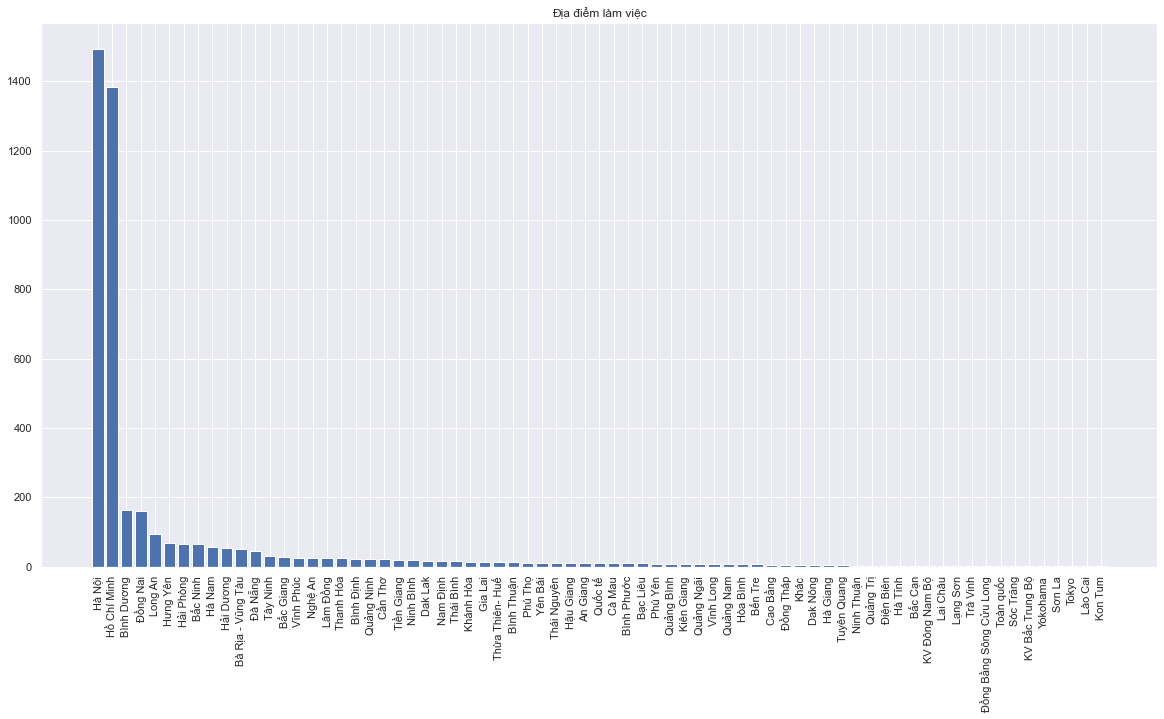

In [44]:
df = ds.to_pandas()
dia_diem_temp = df["dia_diem_lam_viec"].explode().value_counts().sort_values(ascending=False)
x_labels = dia_diem_temp.index
y_values = dia_diem_temp.values
plt.bar(x_labels, y_values)
plt.xticks(rotation=90)
plt.title("Địa điểm làm việc")
plt.show()

In [45]:
def mapper(x):
    if "Hà Nội" in x["dia_diem_lam_viec"]:
        dia_diem_lam_viec_vector = np.array([1, 0, 0])
    elif "Hồ Chí Minh" in x["dia_diem_lam_viec"]:
        dia_diem_lam_viec_vector = np.array([0, 1, 0])
    else:
        dia_diem_lam_viec_vector = np.array([0, 0, 1])
    return {
        "dia_diem_lam_viec_vector": dia_diem_lam_viec_vector,
    }
ds = ds.map(mapper, remove_columns=["dia_diem_lam_viec"])

In [46]:
# feature_values = ['Hà Nội', 'Hồ Chí Minh', None]
# with open('../models/features/dia_diem_lam_viec.json', 'w') as f:
#     json.dump(feature_values, f, ensure_ascii=False)

### 4. Company name feature

Text(0.5, 1.0, 'Top 50 công ty có số lượng tuỳển dụng nhiều nhất')

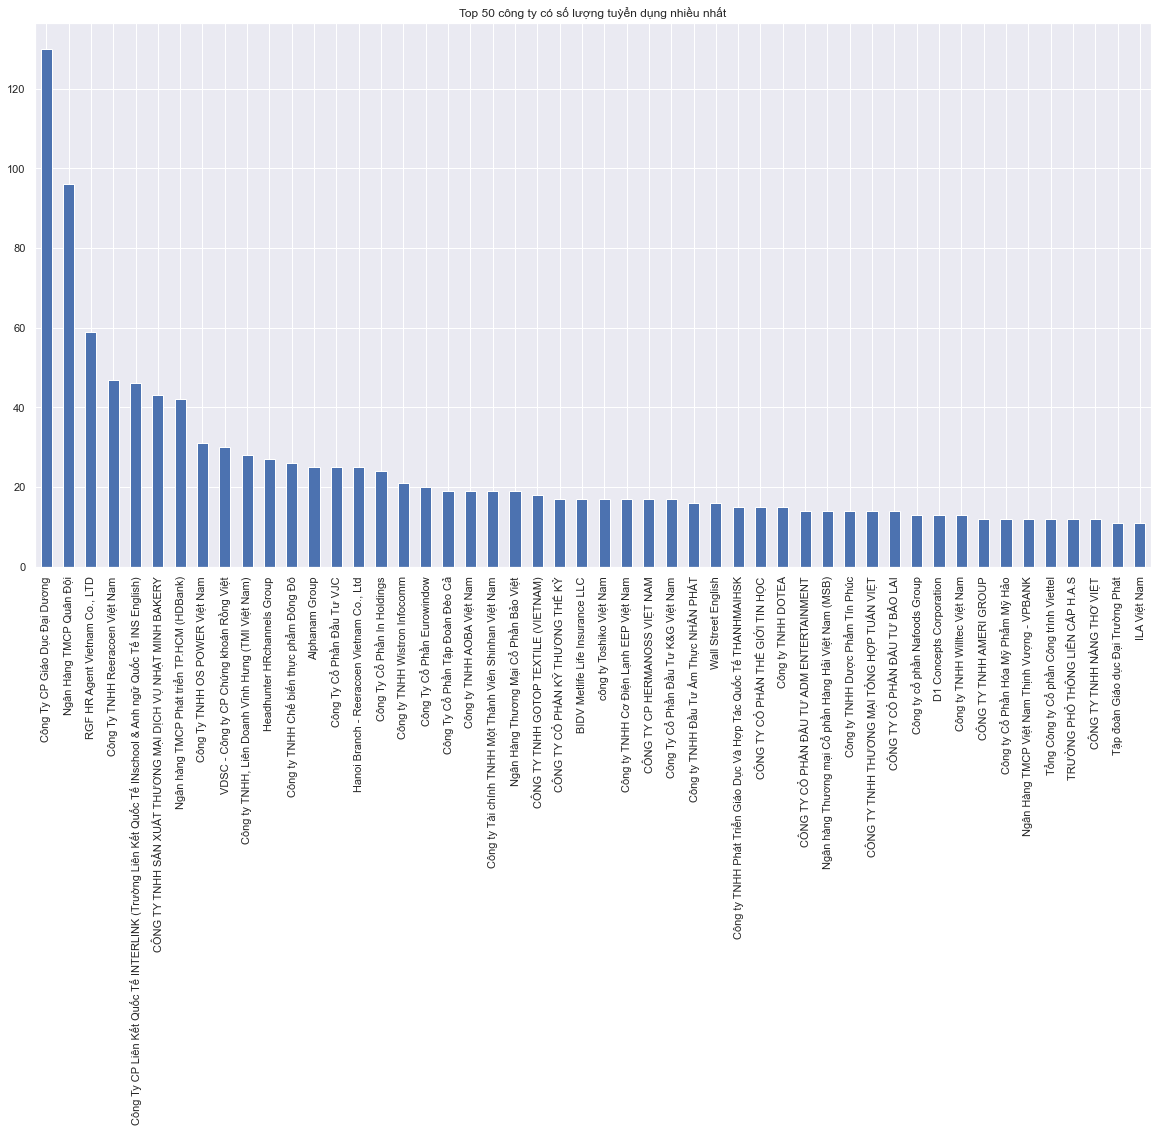

In [47]:
df = ds.to_pandas()
df['ten_cong_ty'].value_counts().sort_values(ascending=False).head(50).plot(kind='bar')
plt.title("Top 50 công ty có số lượng tuỳển dụng nhiều nhất")

In [48]:
threshold = 15
temp = df['ten_cong_ty'].value_counts()
temp = temp[temp > threshold]
temp = temp.to_dict()
dim = len(temp) + 1
def mapper(x):
    ten_cong_ty_vector = np.zeros(dim)
    if x["ten_cong_ty"] in temp:
        ten_cong_ty_vector[list(temp.keys()).index(x["ten_cong_ty"])] = 1
    else:
        ten_cong_ty_vector[-1] = 1
    return {
        "ten_cong_ty_vector": ten_cong_ty_vector,
    }
ds = ds.map(mapper, remove_columns=["ten_cong_ty"])

In [49]:
# feature_values = list(temp.keys()) + [None]
# with open('../models/features/ten_cong_ty.json', 'w') as f:
#     json.dump(feature_values, f, ensure_ascii=False)

### Job title feature

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = ds.to_pandas()
vectorizer = TfidfVectorizer(min_df=0.02)
vectorizer.fit(df["vi_tri_viec"])
print(len(vectorizer.get_feature_names()))

def mapper(x):
    vi_tri_viec_vector = vectorizer.transform([x["vi_tri_viec"]]).toarray()[0]
    return {
        "vi_tri_viec_vector": vi_tri_viec_vector,
    }
ds = ds.map(mapper, remove_columns=["vi_tri_viec"])

72


In [51]:
# import joblib
# joblib.dump(vectorizer, '../models/features/vi_tri_viec_vectorizer.joblib')

### Job kind feature

Text(0.5, 1.0, 'Top 50 ngành nghề có số lượng tuỳển dụng nhiều nhất')

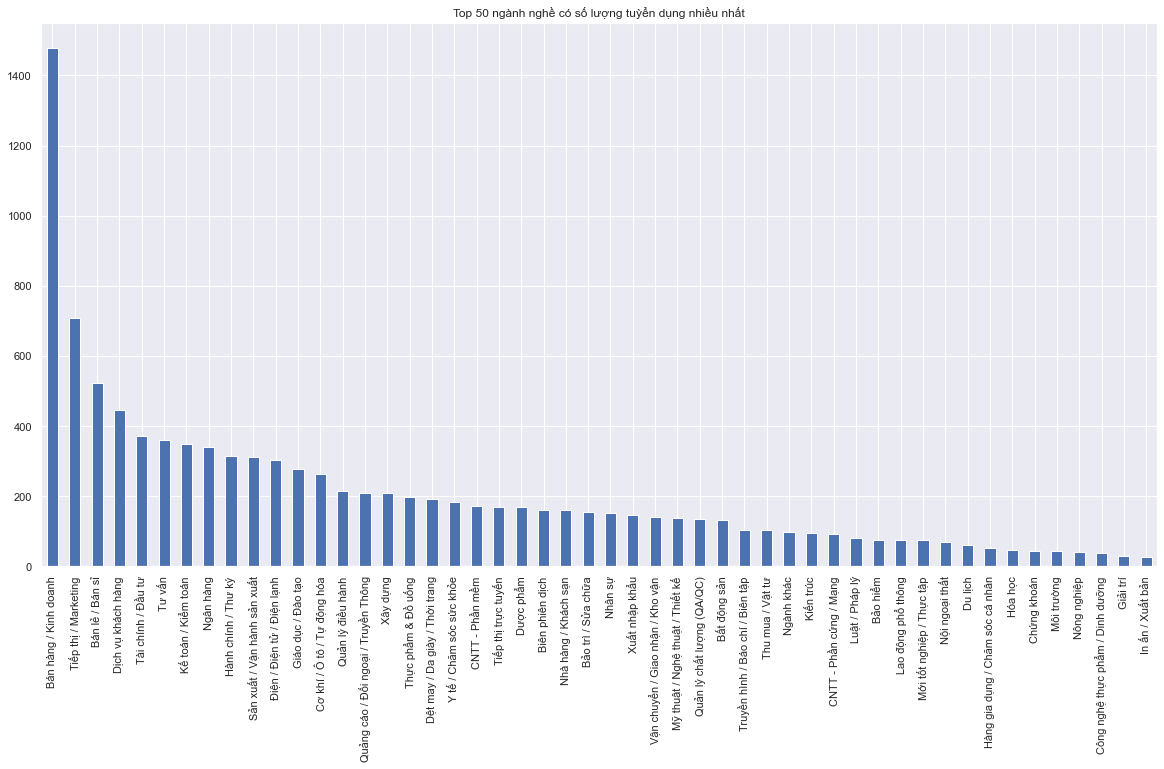

In [52]:
df = ds.to_pandas()
temp = df["nganh_nghe"].explode().value_counts()
temp.sort_values(ascending=False).head(50).plot(kind="bar")
plt.title("Top 50 ngành nghề có số lượng tuỳển dụng nhiều nhất")

In [53]:
threshold = 25
# temp = temp[temp > threshold]
temp = temp.to_dict()
dim = len(temp) + 1
def mapper(x):
    nganh_nghe_vector = np.zeros(dim)
    for nganh_nghe in x["nganh_nghe"]:
        if nganh_nghe in temp:
            nganh_nghe_vector[list(temp.keys()).index(nganh_nghe)] = 1
        else:
            nganh_nghe_vector[-1] = 1
    
    return {
        "nganh_nghe_vector": nganh_nghe_vector,
    }
ds = ds.map(mapper, remove_columns=["nganh_nghe"])

In [54]:
# feature_values = list(temp.keys()) + [None]
# with open('../models/features/nganh_nghe.json', 'w') as f:
#     json.dump(feature_values, f, ensure_ascii=False)

### Hình thức làm việc

Text(0.5, 1.0, 'Hình thức làm việc')

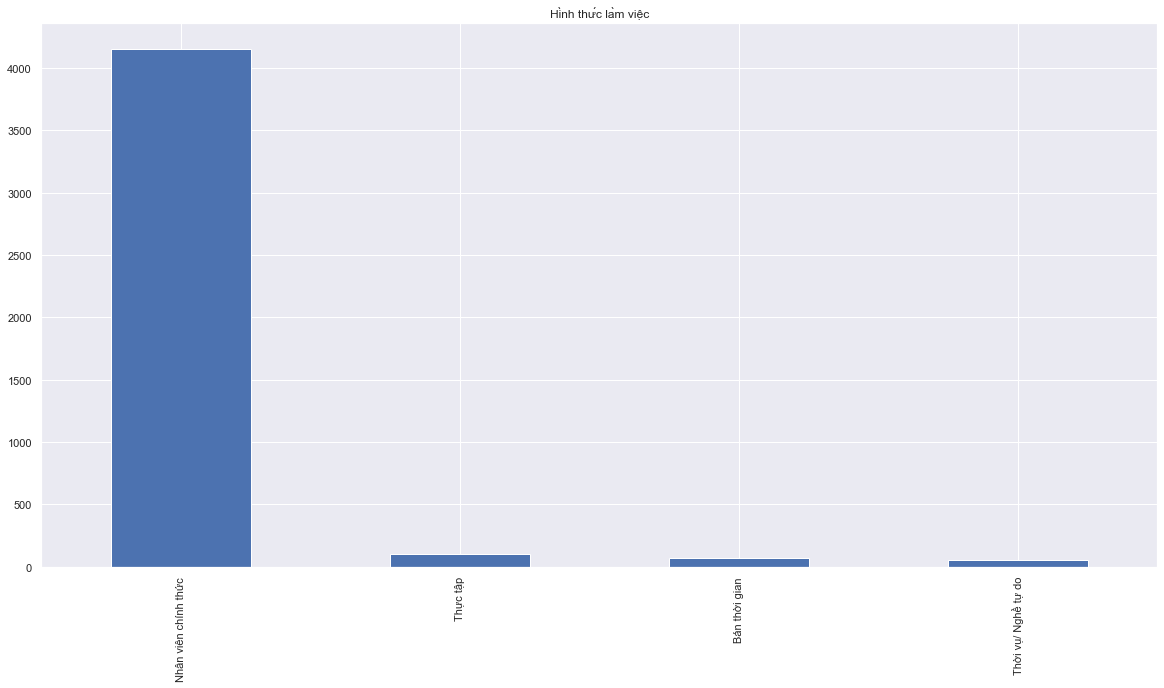

In [55]:
df = ds.to_pandas()
df['hinh_thuc'].explode().value_counts().sort_values(ascending=False).head(50).plot(kind='bar')
plt.title("Hình thức làm việc")

In [56]:
dim = len(df["hinh_thuc"].explode().value_counts())
def mapper(x):
    hinh_thuc_vector = np.zeros(dim)
    for hinh_thuc in x["hinh_thuc"]:
        hinh_thuc_vector[list(df["hinh_thuc"].explode().value_counts().index).index(hinh_thuc)] = 1
    return {
        "hinh_thuc_vector": hinh_thuc_vector,
    }
ds = ds.map(mapper, remove_columns=["hinh_thuc"])

In [57]:
# feature_values = list(df["hinh_thuc"].explode().value_counts().index)
# with open('../models/features/hinh_thuc.json', 'w') as f:
#     json.dump(feature_values, f, ensure_ascii=False)

### Cấp bậc

<AxesSubplot:>

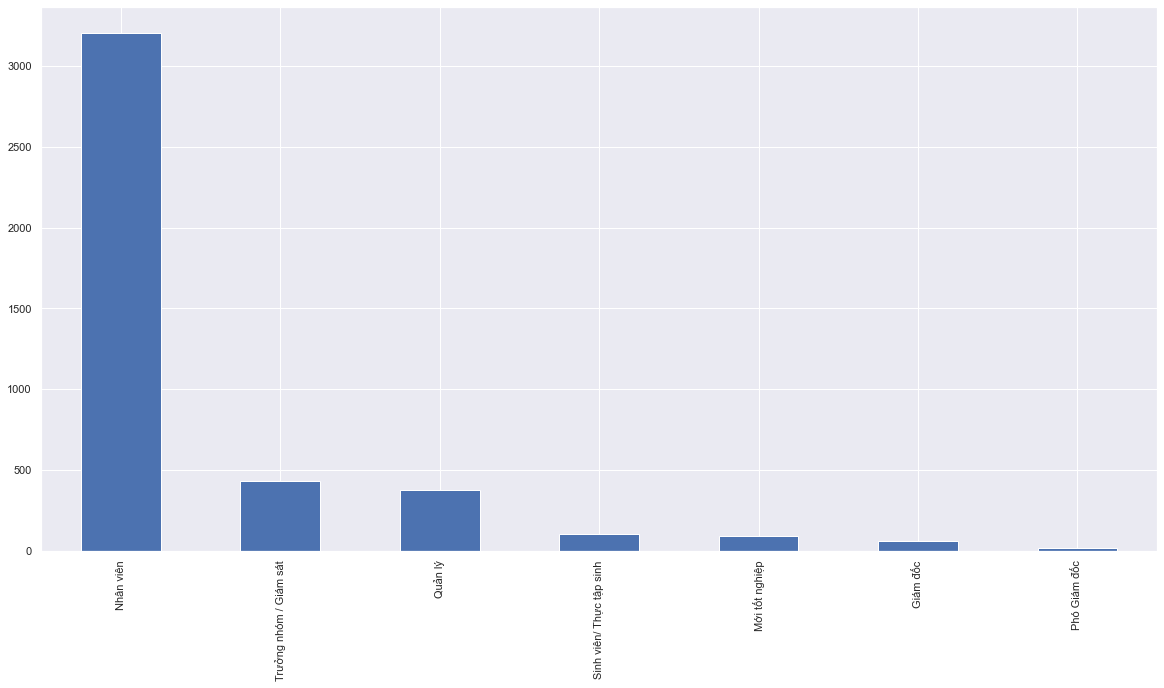

In [58]:
df = ds.to_pandas()
df['cap_bac'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [59]:
temp = df['cap_bac'].value_counts()
dim = len(temp)
def mapper(x):
    cap_bac_vector = np.zeros(dim)
    cap_bac_vector[list(temp.index).index(x["cap_bac"])] = 1
    return {
        "cap_bac_vector": cap_bac_vector,
    }
ds = ds.map(mapper, remove_columns=["cap_bac"])

In [60]:
# feature_values = list(temp.index)
# with open('../models/features/cap_bac.json', 'w') as f:
#     json.dump(feature_values, f, ensure_ascii=False)

### Loại hình hoạt động

In [61]:
df['loai_hinh_hoat_dong'].isna().sum()

301

Text(0.5, 1.0, 'Loại hình hoạt động')

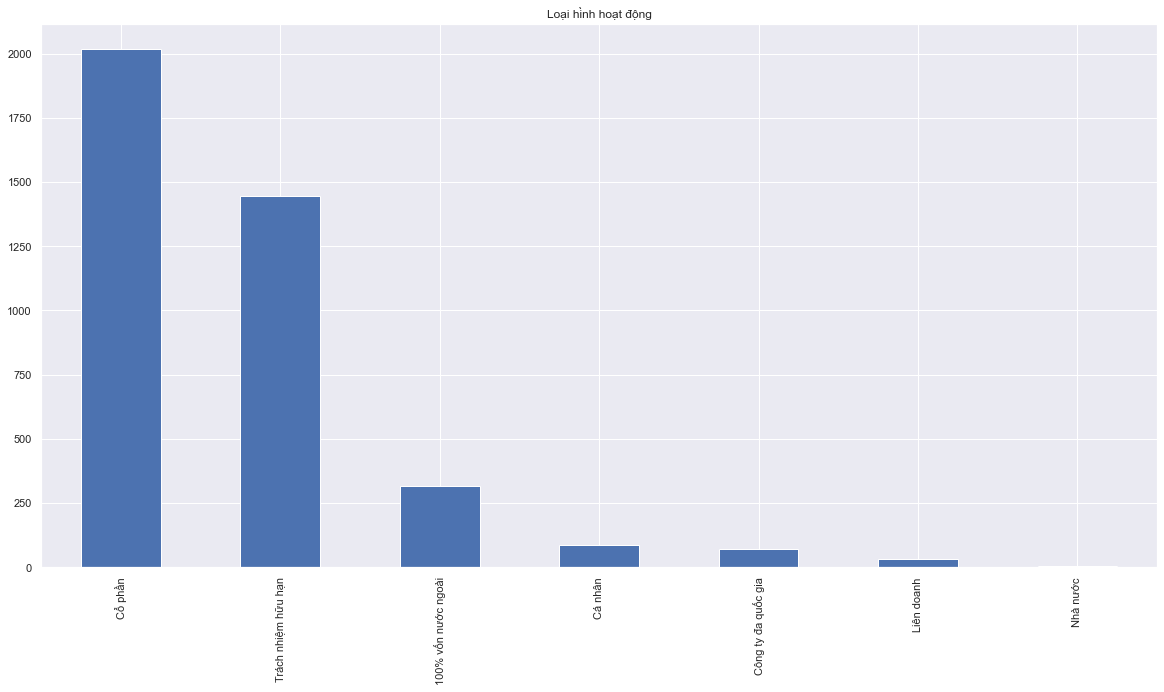

In [62]:
df['loai_hinh_hoat_dong'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title("Loại hình hoạt động")

In [63]:
temp = df['loai_hinh_hoat_dong'].value_counts()
dim = len(temp) + 1
def mapper(x):
    loai_hinh_hoat_dong_vector = np.zeros(dim) 
    if x["loai_hinh_hoat_dong"] in temp:
        loai_hinh_hoat_dong_vector[list(temp.index).index(x["loai_hinh_hoat_dong"])] = 1
    else:
        loai_hinh_hoat_dong_vector[-1] = 1
    return {
        "loai_hinh_hoat_dong_vector": loai_hinh_hoat_dong_vector,
    }
ds = ds.map(mapper, remove_columns=["loai_hinh_hoat_dong"])


Map:   0%|          | 0/4274 [00:00<?, ? examples/s]

In [64]:
# feature_values = list(temp.index) + [None]
# with open('../models/features/loai_hinh_hoat_dong.json', 'w') as f:
#     json.dump(feature_values, f, ensure_ascii=False)

### Quy mô công ty

In [65]:
df = ds.to_pandas()
temp = df['quy_mo_cong_ty'].value_counts().sort_values(ascending=False)
valid_index = [i for i in temp.index if '-' in i]
ranges = [
  (0, 25),
  (25, 99),
  (100, 499),
  (500, 1000),
  (1000, 999999)
]
import re
def mapper(x):
    quy_mo_cong_ty_vector = np.zeros(len(ranges) + 1)
    if x["quy_mo_cong_ty"] is None:
        quy_mo_cong_ty_vector[-1] = 1
    elif '-' in x["quy_mo_cong_ty"]:
        x['quy_mo_cong_ty'] = x['quy_mo_cong_ty'].replace(',', '').replace('.', '')
        m = (int(x["quy_mo_cong_ty"].split('-')[0]) + int(x["quy_mo_cong_ty"].split('-')[1])) / 2
        for i, r in enumerate(ranges):
            if r[0] <= m <= r[1]:
                quy_mo_cong_ty_vector[i] = 1
                break
    else:
        x['quy_mo_cong_ty'] = x['quy_mo_cong_ty'].replace(',', '').replace('.', '')
        for i, r in enumerate(ranges):
            n = int(re.findall(r'\d+', x["quy_mo_cong_ty"])[0])
            if r[0] <= n <= r[1]:
                quy_mo_cong_ty_vector[i] = 1
                break
    return {
        "quy_mo_cong_ty_vector": quy_mo_cong_ty_vector,
    }

ds = ds.map(mapper)

Map:   0%|          | 0/4274 [00:00<?, ? examples/s]

In [71]:
ds.to_pandas()['quy_mo_cong_ty']

0             25-99
1         1000-4999
2              None
3           100-499
4           100-499
           ...     
4269           None
4270    10000-19999
4271    10000-19999
4272           None
4273           None
Name: quy_mo_cong_ty, Length: 4274, dtype: object

In [693]:
# feature_values = [(r[0], r[1]) for r in ranges] + [None]
# with open('../models/features/quy_mo_cong_ty.json', 'w') as f:
#     json.dump(feature_values, f, ensure_ascii=False)

In [85]:
df = ds.to_pandas()
# convert back to index
df['quy_mo_cong_ty_vector'] = df['quy_mo_cong_ty_vector'].apply(lambda x: None if np.argmax(x) == 5 else ranges[np.argmax(x)])
temp = df['quy_mo_cong_ty_vector'].value_counts()
temp
# temp.plot(kind='bar')
# plt.title("Quy mô công ty")
# plt.xlabel("Quy mô")
# plt.ylabel("Số lượng")
# plt.show()

(100, 499)        1278
(25, 99)           883
(500, 1000)        515
(1000, 999999)     512
(0, 25)            225
Name: quy_mo_cong_ty_vector, dtype: int64

### Number of followers

In [694]:
            bins = [
            (0, 25),
            (25, 99),
            (100, 499),
            (500, 1000),
            (1000, 2000),
            (2000, 5000),
            (5000, 10000),
            (10000, 999999)
            ]

dim = len(bins) + 1
def mapper(x):
    num_followers_vector = np.zeros(dim)
    if x["num_followers"] is None:
        num_followers_vector[-1] = 1
    else:
        for i, r in enumerate(bins):
            if r[0] <= x["num_followers"] <= r[1]:
                num_followers_vector[i] = 1
                break
    return {
        "num_followers_vector": num_followers_vector,
    }
ds = ds.map(mapper, remove_columns=["num_followers"])

Map:   0%|          | 0/4274 [00:00<?, ? examples/s]

In [695]:
feature_values = [(r[0], r[1]) for r in bins] + [None]
with open('../models/features/num_followers.json', 'w') as f:
    json.dump(feature_values, f, ensure_ascii=False)

In [449]:
def mapper(x):
    return {
        "min_exp_vector": np.array([x["min_exp"]]),
        "max_exp_vector": np.array([x["max_exp"]]),
    }
ds = ds.map(mapper, remove_columns=["min_exp", "max_exp"])

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-22972fb5f0b77ce3/0.0.0/cache-f54c908149af5c8b.arrow


In [450]:
seleted_columns = [col for col in ds.column_names if col.endswith("_vector") or col in ["min_luong", "max_luong"]]
ds = ds.select_columns(seleted_columns)

In [451]:
def mapper(x):
    return {
        "features": np.concatenate([x[col] for col in seleted_columns if col not in ["min_luong", "max_luong"]]),
        "targets_min": x["min_luong"],
        "targets_max": x["max_luong"],
    }
ds = ds.map(mapper, remove_columns=seleted_columns)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-22972fb5f0b77ce3/0.0.0/cache-6bf902fd859d2a90.arrow


In [539]:
def min_filter(x):
    return x["targets_min"] is not None and x["targets_min"] <= 200


def min_range_mapper(x):
    ranges = [
        (0, 5),
        (5, 10),
        (10, 15),
        (15, 20),
        (20, 25),
        (25, 30),
        (30, 50),
        (50, 75),
        (75, 100),
        (100, 999999),
    ]
    for i, r in enumerate(ranges):
        if r[0] <= x["targets_min"] <= r[1]:
            return {
                "targets_min_range": i,
            }


ds_min = ds.filter(min_filter)
ds_min = ds_min.map(min_range_mapper)


def max_filter(x):
    return x["targets_max"] is not None and x["targets_max"] <= 200


def max_range_mapper(x):
    ranges = [
        (0, 5),
        
        (10, 20),
        (20, 30),
        (30, 50),
        (50, 75),
        (75, 100),
        (100, 999999),
    ]
    for i, r in enumerate(ranges):
        if r[0] <= x["targets_max"] <= r[1]:
            return {
                "targets_max_range": i,
            }


ds_max = ds.filter(max_filter)
ds_max = ds_max.map(max_range_mapper)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-22972fb5f0b77ce3/0.0.0/cache-ec7ab9c26e630541.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-22972fb5f0b77ce3/0.0.0/cache-8639b825bdfa76ad.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-22972fb5f0b77ce3/0.0.0/cache-dafa78df3fc261b2.arrow


Map:   0%|          | 0/3992 [00:00<?, ? examples/s]

In [540]:
temp = ds_min.train_test_split(test_size=0.1, seed=42)
ds_train_min = temp["train"]
ds_test_min = temp["test"]
X_train_min, y_train_min = ds_train_min["features"], ds_train_min["targets_min_range"]
X_test_min, y_test_min = ds_test_min["features"], ds_test_min["targets_min_range"]

Loading cached split indices for dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-22972fb5f0b77ce3/0.0.0/cache-dfa911d49837c768.arrow and /Users/phamhoang1408/.cache/huggingface/datasets/json/default-22972fb5f0b77ce3/0.0.0/cache-eac2509281a23baf.arrow


In [541]:
from sklearn.ensemble import RandomForestClassifier

In [632]:
model = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)
model.fit(X_train_min, y_train_min)

y_test_min_pred = model.predict(X_test_min)
print(classification_report(y_test_min, y_test_min_pred))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        19
           1       0.65      0.92      0.76       187
           2       0.48      0.45      0.47       117
           3       0.55      0.24      0.33        46
           4       1.00      0.11      0.19        19
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         1

    accuracy                           0.60       419
   macro avg       0.40      0.28      0.29       419
weighted avg       0.57      0.60      0.55       419



In [656]:
sample = ds_test_min.shuffle()[0]
y_pred = model.predict(np.array(sample["features"]).reshape(1, -1))
print("Predicted:", y_pred[0])
print("Actual:", sample["targets_min_range"], sample["targets_min"])

Predicted: 1
Actual: 1 8.0


In [629]:
temp = ds_max.train_test_split(test_size=0.1, seed=43)
ds_train_max = temp["train"]
ds_test_max = temp["test"]
X_train_max, y_train_max = ds_train_max["features"], ds_train_max["targets_max_range"]
X_test_max, y_test_max = ds_test_max["features"], ds_test_max["targets_max_range"]

model = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)
model.fit(X_train_max, y_train_max)
model.score(X_test_max, y_test_max)

Loading cached split indices for dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-22972fb5f0b77ce3/0.0.0/cache-0b6597944326fb83.arrow and /Users/phamhoang1408/.cache/huggingface/datasets/json/default-22972fb5f0b77ce3/0.0.0/cache-80f5c67bdb5d5cd1.arrow


0.63

In [630]:
from sklearn.metrics import classification_report
y_test_max_pred = model.predict(X_test_max)
print(classification_report(y_test_max, y_test_max_pred))

              precision    recall  f1-score   support

           0       1.00      0.12      0.21        60
           1       0.63      0.99      0.77       232
           2       0.56      0.15      0.24        65
           3       0.45      0.20      0.28        25
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         3

    accuracy                           0.63       400
   macro avg       0.38      0.21      0.21       400
weighted avg       0.64      0.63      0.54       400



              precision    recall  f1-score   support

           0       0.83      0.53      0.65        19
           1       0.49      0.97      0.65       187
           2       0.08      0.02      0.03       117
           3       0.15      0.04      0.07        46
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         1

    accuracy                           0.47       419
   macro avg       0.17      0.17      0.16       419
weighted avg       0.30      0.47      0.34       419



In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

with open('../models/features/cap_bac.json', 'r') as f:
    cap_bac_feature_values = json.load(f)
with open('../models/features/dia_diem_lam_viec.json', 'r') as f:
    dia_diem_lam_viec_feature_values = json.load(f)
with open('../models/features/hinh_thuc.json', 'r') as f:
    hinh_thuc_feature_values = json.load(f)
with open('../models/features/loai_hinh_hoat_dong.json', 'r') as f:
    loai_hinh_hoat_dong_feature_values = json.load(f)
with open('../models/features/nganh_nghe.json', 'r') as f:
    nganh_nghe_feature_values = json.load(f)
with open('../models/features/quy_mo_cong_ty.json', 'r') as f:
    quy_mo_cong_ty_feature_values = json.load(f)
with open('../models/features/ten_cong_ty.json', 'r') as f:
    ten_cong_ty_feature_values = json.load(f)

with open('../models/features/num_followers.json', 'r') as f:
    num_followers_feature_values = json.load(f)

vi_tri_viec_vectorizer = joblib.load('../models/features/vi_tri_viec_vectorizer.joblib')

def convert_raw_data_to_feature(raw_data):
    def convert_text_unique_to_feature(feature_values, value):
        vector = np.zeros(len(feature_values))
        if value in feature_values:
            vector[feature_values.index(value)] = 1
        elif None in feature_values:
            vector[-1] = 1
        return vector
    def convert_numeric_to_feature(ranges, value):
        vector = np.zeros(len(ranges))
        if value is None:
            vector[-1] = 1
        else:
            for i, r in enumerate(ranges):
                if r[0] <= value <= r[1]:
                    vector[i] = 1
                    break
        return vector
    
    def convert_tf_idf_to_feature(vectorizer, value):
        return vectorizer.transform([value]).toarray()[0]

    feature_vector = np.concatenate([
        convert_text_unique_to_feature(cap_bac_feature_values, raw_data["cap_bac"]),
        convert_text_unique_to_feature(dia_diem_lam_viec_feature_values, raw_data["dia_diem_lam_viec"]),
        convert_text_unique_to_feature(hinh_thuc_feature_values, raw_data["hinh_thuc"]),
        convert_text_unique_to_feature(loai_hinh_hoat_dong_feature_values, raw_data["loai_hinh_hoat_dong"]),
        convert_text_unique_to_feature(nganh_nghe_feature_values, raw_data["nganh_nghe"]),
        convert_text_unique_to_feature(quy_mo_cong_ty_feature_values, raw_data["quy_mo_cong_ty"]),
        convert_text_unique_to_feature(ten_cong_ty_feature_values, raw_data["ten_cong_ty"]),
        convert_tf_idf_to_feature(vi_tri_viec_vectorizer, raw_data["vi_tri_viec"]),
        convert_numeric_to_feature(num_followers_feature_values, raw_data["num_followers"]),
    ])
    return feature_vector
